In [ ]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

TensorFlow 2.x selected.
     |████████████████████████████████| 378kB 6.8MB/s 


In [ ]:
# Per sapere che GPU si sta utilizzando

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier


from xgboost.sklearn import XGBClassifier
import xgboost

from keras import models, layers, optimizers, metrics, callbacks


from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data

In [ ]:
data = pd.read_csv('/content/drive/My Drive/progetto_aml/dataset/train_prepocessed.csv')

In [ ]:
data.head()

,id,age,country_destination,year_first_active,time_lag,month_first_active_sin,month_first_active_cos,day_first_active_sin,day_first_active_cos,weekday_first_active_sin,weekday_first_active_cos,10_count,12_count,15_count,account_count,active_count,agree_terms_check_count,ajax_check_dates_count,ajax_get_referrals_amt_count,ajax_image_upload_count,ajax_lwlb_contact_count,ajax_photo_widget_form_iframe_count,ajax_referral_banner_experiment_type_count,ajax_referral_banner_type_count,ajax_refresh_subtotal_count,ajax_statsd_count,apply_coupon_click_count,apply_coupon_error_count,apply_coupon_error_type_count,apply_reservation_count,ask_question_count,at_checkpoint_count,authenticate_count,authorize_count,available_count,calendar_tab_inner2_count,callback_count,campaigns_count,cancellation_policies_count,cancellation_policy_click_count,...,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_Firefox,first_browser_IE,first_browser_Mobile Safari,first_browser_Opera,first_browser_Safari,first_browser_Silk,first_browser_other,most_used_device_-unknown-,most_used_device_Android App Unknown Phone/Tablet,most_used_device_Android Phone,most_used_device_Blackberry,most_used_device_Chromebook,most_used_device_Linux Desktop,most_used_device_Mac Desktop,most_used_device_Opera Phone,most_used_device_Tablet,most_used_device_Windows Desktop,most_used_device_Windows Phone,most_used_device_iPad Tablet,most_used_device_iPhone,most_used_device_iPodtouch
0,gxn3p5htnn,-99.000000,NDF,-4.2844,38.998181,0.866025,5.000000e-01,-0.485302,-0.874347,0.974928,-0.222521,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,820tgsjxq7,0.120931,NDF,-4.2844,61.207505,0.866025,-5.000000e-01,-0.968077,-0.250653,-0.433884,-0.900969,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,1.659553,US,-4.2844,39.769788,0.500000,-8.660254e-01,0.998717,-0.050649,0.000000,1.000000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,0.462847,other,-4.2844,64.009588,-1.000000,-1.836970e-16,-0.201299,0.979530,-0.433884,-0.900969,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,0.377368,US,-4.2844,23.430341,-0.500000,8.660254e-01,0.988468,0.151428,0.000000,1.000000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Funzioni utilli

In [ ]:
# Funzioni per calcolare ndcg

def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) ))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)



ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [ ]:
# Top_n accuracy

def top_n_accuracy(y_true, y_pred_prob, n = 5):
    topn = np.argsort(y_pred_prob, axis = 1)[:,-n:]
    acc = np.mean(np.array([1 if y_true[k] in topn[k] else 0 for k in range(len(topn))]))
    return(acc)

# Classificatori

## SVM (Molto lento, non verrà più sviluppata)

In [ ]:
from sklearn.svm import SVC

clf3 = SVC(kernel='rbf', class_weight='balanced',
           decision_function_shape='ovo', probability=True, cache_size = 2000)


In [ ]:
clf3 = clf3.fit(X_train, y_train)

In [ ]:
y_pred_prob = clf3.predict_proba(X_test.values)

In [ ]:
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

## XGboost

In [ ]:
data_prova = data.copy()

In [ ]:
data_prova.drop("id", axis = 1, inplace = True)

In [ ]:
X_train, X_test = train_test_split(data_prova, test_size = 0.2, stratify = data_prova["country_destination"], random_state = 42)

In [ ]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [ ]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [ ]:
xgb = XGBClassifier(max_depth=7, learning_rate=0.18, n_estimators=100,
                    objective='multi:softprob', colsample_bytree=1, 
                    seed=42, n_jobs = -1, tree_method = "gpu_hist", max_delta_step = 1)

In [ ]:
xgb.fit(X_train.values, y_train, 
        eval_set = [(X_train.values, y_train), (X_test.values, y_test)], 
        eval_metric = "mlogloss",
        early_stopping_rounds=3)

[0]	validation_0-mlogloss:2.2987	validation_1-mlogloss:2.3
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 3 rounds.
[1]	validation_0-mlogloss:2.12366	validation_1-mlogloss:2.12617
[2]	validation_0-mlogloss:1.96192	validation_1-mlogloss:1.96565
[3]	validation_0-mlogloss:1.81378	validation_1-mlogloss:1.81917
[4]	validation_0-mlogloss:1.68032	validation_1-mlogloss:1.68733
[5]	validation_0-mlogloss:1.56482	validation_1-mlogloss:1.57354
[6]	validation_0-mlogloss:1.46652	validation_1-mlogloss:1.47681
[7]	validation_0-mlogloss:1.38372	validation_1-mlogloss:1.39565
[8]	validation_0-mlogloss:1.31695	validation_1-mlogloss:1.33048
[9]	validation_0-mlogloss:1.26337	validation_1-mlogloss:1.27854
[10]	validation_0-mlogloss:1.21968	validation_1-mlogloss:1.23649
[11]	validation_0-mlogloss:1.18394	validation_1-mlogloss:1.20228
[12]	validation_0-mlogloss:1.15416	validation_1-mlogloss:1.17398
[13]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.18, max_delta_step=1, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=56, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

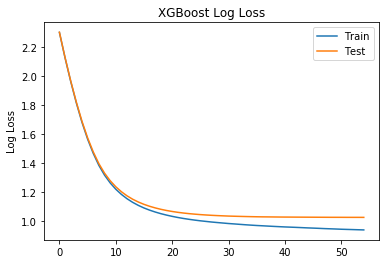

In [ ]:
results = xgb.evals_result()
epochs = len(results['validation_1']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [ ]:
y_pred_prob = xgb.predict_proba(X_test.values)

In [ ]:
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

0.8314356537395007

In [ ]:
top_n_accuracy(encoded_y_test, y_pred_prob)

0.9587500878405284

### Prova con XGBoost e dataset bilanciato (peggio del normale, non verrà più sviluppata)

In [ ]:
data_prova = data.copy()

In [ ]:
data_prova.pop("id")

0         gxn3p5htnn
1         820tgsjxq7
2         4ft3gnwmtx
3         bjjt8pjhuk
4         87mebub9p4
             ...    
213446    zxodksqpep
213447    mhewnxesx9
213448    6o3arsjbb4
213449    jh95kwisub
213450    nw9fwlyb5f
Name: id, Length: 213451, dtype: object

In [ ]:
# Per bilanciare il Dataset

num = data_prova.country_destination.value_counts()[-1]

df_majority = data_prova[data_prova.country_destination=="NDF"]
df_minority = data_prova[data_prova.country_destination=="US"]
df_minority1 = data_prova[data_prova.country_destination=="FR"]
df_minority2 = data_prova[data_prova.country_destination=="other"]
df_minority3 = data_prova[data_prova.country_destination=="ES"]
df_minority4 = data_prova[data_prova.country_destination=="IT"]
df_minority5 = data_prova[data_prova.country_destination=="GB"]
df_minority6 = data_prova[data_prova.country_destination=="CA"]
df_minority7 = data_prova[data_prova.country_destination=="DE"]
df_minority8 = data_prova[data_prova.country_destination=="NL"]
df_minority9 = data_prova[data_prova.country_destination=="AU"]
df_minority10 = data_prova[data_prova.country_destination=="PT"]

In [ ]:
X_train = df_majority[:num].append([df_minority[:num], df_minority1[:num], 
                         df_minority2[:num], df_minority3[:num], df_minority4[:num],
                         df_minority5[:num], df_minority6[:num], df_minority7[:num],
                         df_minority8[:num], df_minority9[:num], df_minority10[:num]], ignore_index = True)

In [ ]:
X_train.country_destination.value_counts()

In [ ]:
X_train = X_train.sample(frac=1)

In [ ]:
X_train, X_test = train_test_split(X_train, test_size = 0.2, stratify = X_train["country_destination"], random_state = 42)

In [ ]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [ ]:
label_encoder = LabelEncoder()
encoded_y_test = label_encoder.fit_transform(y_test)

In [ ]:
xgb = XGBClassifier(max_depth=7, learning_rate=0.18, n_estimators=100,
                    objective='multi:softprob', colsample_bytree=1, seed=42, n_jobs = -1, tree_method='gpu_hist')

In [ ]:
xgb.fit(X_train.values, y_train, 
        eval_set = [(X_train.values, y_train), (X_test.values, y_test)], 
        eval_metric = "mlogloss",
        early_stopping_rounds=3)

[0]	validation_0-mlogloss:2.18833	validation_1-mlogloss:2.27581
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 3 rounds.
[1]	validation_0-mlogloss:1.99022	validation_1-mlogloss:2.15738
[2]	validation_0-mlogloss:1.83202	validation_1-mlogloss:2.05723
[3]	validation_0-mlogloss:1.70004	validation_1-mlogloss:1.98729
[4]	validation_0-mlogloss:1.59213	validation_1-mlogloss:1.93114
[5]	validation_0-mlogloss:1.49938	validation_1-mlogloss:1.88335
[6]	validation_0-mlogloss:1.42225	validation_1-mlogloss:1.84768
[7]	validation_0-mlogloss:1.35058	validation_1-mlogloss:1.81487
[8]	validation_0-mlogloss:1.28993	validation_1-mlogloss:1.7915
[9]	validation_0-mlogloss:1.23129	validation_1-mlogloss:1.76932
[10]	validation_0-mlogloss:1.17941	validation_1-mlogloss:1.75482
[11]	validation_0-mlogloss:1.13276	validation_1-mlogloss:1.73934
[12]	validation_0-mlogloss:1.08789	validation_1-mlogloss:1.73198


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.18, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

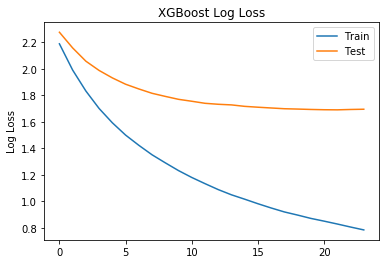

In [ ]:
results = xgb.evals_result()
epochs = len(results['validation_1']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [ ]:
y_pred_prob = xgb.predict_proba(X_test.values)

In [ ]:
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

0.6385147094325264

In [ ]:
top_n_accuracy(encoded_y_test, y_pred_prob)

0.8790786948176583

## Neural Network

In [ ]:
data_prova = data.copy()

In [ ]:
data_prova.drop("id", axis = 1, inplace = True)

In [ ]:
X_train, X_test = train_test_split(data_prova, test_size = 0.2, stratify = data_prova["country_destination"], random_state = 42)

In [ ]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [ ]:
label_encoder = LabelEncoder()

encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(encoded_y_train),
                                                 encoded_y_train)

In [ ]:
n_classes = len(np.unique(y_train))
n_features = X_train.shape[1]

In [ ]:
model = models.Sequential()

model.add(layers.Dense(n_features, input_dim =  n_features, activation = "relu"))
#model.add(layers.Dense(64, activation = "relu"))
#model.add(layers.Dense(32, activation = "relu"))
#model.add(layers.Dense(128, activation = "elu"))
model.add(layers.Dense(n_classes, activation="softmax"))

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=["acc"])

In [ ]:
history = model.fit(X_train.values, encoded_y_train, 
                    batch_size = 16,
                    epochs = 10,
                    class_weight = class_weights, 
                    validation_split = 0.3)

Train on 119531 samples, validate on 51229 samples
Epoch 1/10
119531/119531 [==============================] - 32s 267us/step - loss: 2.1154 - acc: 0.5812 - val_loss: 1.0983 - val_acc: 0.6143
Epoch 2/10
119531/119531 [==============================] - 30s 251us/step - loss: 1.1133 - acc: 0.6035 - val_loss: 1.1048 - val_acc: 0.6091
Epoch 3/10
119531/119531 [==============================] - 30s 253us/step - loss: 1.1032 - acc: 0.6108 - val_loss: 1.0995 - val_acc: 0.5996
Epoch 4/10
119531/119531 [==============================] - 30s 252us/step - loss: 1.0916 - acc: 0.6145 - val_loss: 1.1162 - val_acc: 0.6076
Epoch 5/10
119531/119531 [==============================] - 30s 253us/step - loss: 1.0838 - acc: 0.6188 - val_loss: 1.1169 - val_acc: 0.6064
Epoch 6/10
119531/119531 [==============================] - 30s 254us/step - loss: 1.0834 - acc: 0.6208 - val_loss: 1.0725 - val_acc: 0.6391
Epoch 7/10
119531/119531 [==============================] - 31s 257us/step - loss: 1.0808 - acc: 0.6238

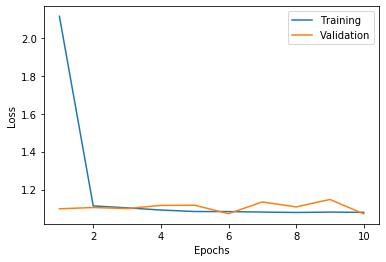

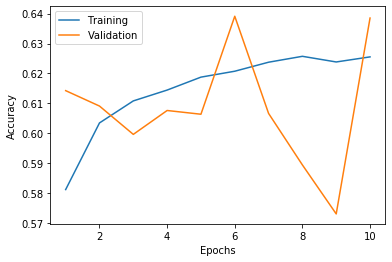

In [ ]:
x_plot = list(range(1,history.epoch[-1]+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['acc'])
    plt.plot(x_plot, network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
plot_history(history)

In [ ]:
y_pred_prob = model.predict(X_test.values)

In [ ]:
ndcg_score(encoded_y_test, y_pred_prob)

0.8279869671207457

### NN one_vs_all (Provata perchè inizialmente non funzionava la rete neurale classica, ora quindi non è più necessaria)

In [ ]:
data_prova = data.copy()

In [ ]:
data_prova.drop("id", axis = 1, inplace = True)

In [ ]:
X_train, X_test = train_test_split(data_prova, test_size = 0.2, stratify = data_prova["country_destination"], random_state = 42)

In [ ]:
y_train = X_train.pop("country_destination")
y_test = X_test.pop("country_destination")

In [ ]:
label_encoder = LabelEncoder()

encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [ ]:
n_classes = len(np.unique(y_train))
n_features = X_train.shape[1]

In [ ]:
def dnn_model(n_comps):
    model = models.Sequential()
    model.add(layers.Dense(n_comps, input_dim=n_comps, activation='relu'))
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation="relu"))
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation='softmax'))

    # compile model
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=[metrics.accuracy])
    return model


In [ ]:
model = KerasClassifier(build_fn=dnn_model, n_comps=n_features, 
                        batch_size = 16,
                        epochs = 1,
                        validation_split = 0.3)
clf = OneVsRestClassifier(model)

In [ ]:
clf.fit(X_train.values, encoded_y_train)

In [ ]:
y_pred_prob = clf.predict_proba(X_test.values)

In [ ]:
ndcg_score(encoded_y_test, y_pred_prob, k = 5)

0.80564852692792

In [ ]:
top_n_accuracy(encoded_y_test, y_pred_prob)

0.9569230048487972

In [ ]:
#Cross validation

cval_scores = cross_val_score(clf, X_train.values, encoded_y_train, cv=5, scoring=ndcg_scorer)
test_score = clf.score(X=X_test.values, y=encoded_y_test)

In [ ]:
cval_scores

array([0.66506884, 0.73680992, 0.66231506, 0.75196868, 0.66950634])

## Random Forest (basato su decision tree come XGBoost), più lento e meno performante, non verrà sviluppato

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf_prob = clf.predict_proba(X_test)

In [ ]:
ndcg_score(encoded_y_test, rf_prob, k = 5)

0.8207023884892175

In [ ]:
top_n_accuracy(encoded_y_test, rf_prob)

0.959663629336394